In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import matplotlib
import h5py

import calculation.MeanFieldv2 as MFv2
import calculation.CurrentMeirv2 as CMv2
import calculation.SusceptibilitySimpv2 as Susceptv2
import calculation.CurrentMeirv2 as CMv2

import settings.Constants as const

In [14]:
def computeGridLines(lim1=1, num_lines1=3, lim2=3, num_lines2=3):
    
    dense_near_zero = np.linspace(0, lim1, num_lines1)
    sparse_far = np.linspace(lim1, lim2, num_lines2)
    
    grid_lines_pos = np.concatenate([dense_near_zero, sparse_far])
    grid_lines_neg = -grid_lines_pos[::-1] 
    
    grid_lines = np.unique(np.concatenate([grid_lines_neg, grid_lines_pos]))
    
    for x_line in grid_lines:
        plt.axvline(x=x_line, color='#b0b0b0', linewidth=0.8, alpha=0.7)

    plt.xticks(grid_lines[::2], [f"{x:.2f}" for x in grid_lines[::2]])
    plt.grid(True, axis='y')

In [15]:
with h5py.File(const.saddlePointFile, 'r') as f:
    saddle_points = f['SaddlePoint/saddle_points'][:]
    couplingValue = f['SaddlePoint/coupling'][()]
    Tvalue = f['SaddlePoint/T'][()]
    voltageSpacePlot = f['SaddlePoint/voltageSpacePlot'][:]
    lambdaSpacePlot = f['SaddlePoint/lambdaSpacePlot'][:]
    
    phi_voltage = f['SaddlePoint/phi-Voltage'][:]
    phi_lambda = f['SaddlePoint/phi-Lambda'][:]
    
    lambdaSamples = f['SaddlePoint/lambdaSamples'][:]
    voltageSamples = f['SaddlePoint/voltageSamples'][:]
    
    colorsVoltage = f['SaddlePoint/colorsVoltage'][:]
    colorsLambda = f['SaddlePoint/colorsLambda'][:]


phiSamples = saddle_points[:,1]

In [16]:
lambdaUpper = lambdaSamples[-1]
lambdaLower = lambdaSamples[0]

voltageZero = voltageSamples[0]
voltageLower = voltageSamples[1]
voltageCritical = voltageSamples[2]
voltageUpper = voltageSamples[-1]

phiZero = phiSamples[0]
phiLower = phiSamples[1]
phiCritical = phiSamples[2]
phiUpper = phiSamples[-1]

phi_voltage_func = scipy.interpolate.interp1d(voltageSpacePlot, phi_voltage[1, :], kind='linear')


omegaSpace = np.linspace(-3, 3, 101)

In [17]:
# plt.plot(voltageSpacePlot, phi_voltage_func(voltageSpacePlot), label='Voltage-Phi')

In [18]:
def MFSpectralFunction(epsilon, omega, phi, lambdaValue, couplingValue):
    num = 2*couplingValue
    den = (omega - epsilon + 2.0*lambdaValue*phi)**2 + couplingValue**2
    return num/den

SpectralEnergyFunc = lambda omega, phi, lambdaValue: scipy.integrate.quad(MFSpectralFunction, -1.0, 1.0, args=(omega, phi, lambdaValue, couplingValue), limit=1000)[0]


SpectraUpper = np.array([SpectralEnergyFunc(omega, phiUpper, lambdaUpper) for omega in omegaSpace])
SpectraLower = np.array([SpectralEnergyFunc(omega, phiLower, lambdaLower) for omega in omegaSpace])


def Ffunc(omega, voltageValue, Tvalue):
    
    beta = 1.0/Tvalue
    value = np.tanh(0.5*beta*(omega - voltageValue/2.0)) + np.tanh(0.5*beta*(omega + voltageValue/2.0))
    
    return 0.5*value
    
    

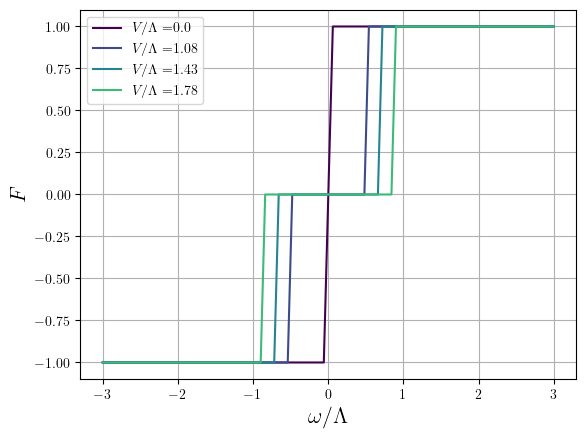

In [19]:

plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
for i in range(voltageSamples.shape[0]):
    plt.plot(omegaSpace, Ffunc(omegaSpace, voltageSamples[i], Tvalue), label=r'$V/\Lambda = $'+str(round(voltageSamples[i], 2)), color=colorsVoltage[i])
plt.legend()
plt.grid()
plt.xlabel(r'$\omega/\Lambda$', fontsize=16)
plt.ylabel(r'$F$', fontsize=16)
plt.savefig('figures/FfuncMF.pdf')

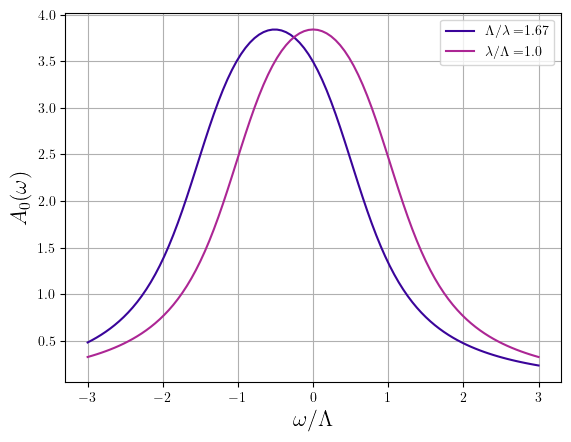

In [20]:
plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.plot(omegaSpace, SpectraLower, label=r'$\Lambda/\lambda =$'+str(round(1.0/lambdaSamples[0], 2)), color=colorsLambda[0])
plt.plot(omegaSpace, SpectraUpper, label=r'$\lambda/\Lambda =$'+str(round(1.0/lambdaSamples[-1], 2)), color=colorsLambda[1])
plt.legend()
plt.xlabel(r'$\omega/\Lambda$', fontsize=16)
plt.ylabel(r'$A_0(\omega)$', fontsize=16)
plt.grid()
plt.savefig('figures/SpectralFunctionMF.pdf')

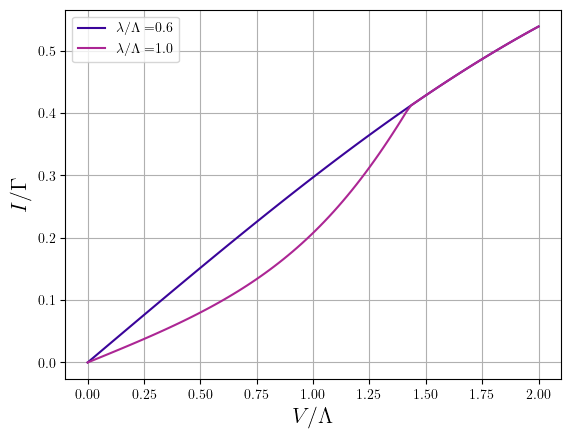

In [21]:

### current plots

currentLowerLambda = np.array([CMv2.computeCurrent(lambdaLower, 0.0, voltageValue, couplingValue, Tvalue) for voltageValue in voltageSpacePlot])
currentUpperLambda = np.array([CMv2.computeCurrent(lambdaUpper, phi_voltage_func(voltageValue), voltageValue, couplingValue, Tvalue) for voltageValue in voltageSpacePlot])



plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.plot(voltageSpacePlot, currentLowerLambda/couplingValue, label=r'$\lambda/\Lambda =$'+str(round(lambdaSamples[0], 2)), color=colorsLambda[0])
plt.plot(voltageSpacePlot, currentUpperLambda/couplingValue, label=r'$\lambda/\Lambda =$'+str(round(lambdaSamples[-1], 2)), color=colorsLambda[1])
plt.grid()
plt.legend()
plt.xlabel(r'$V/\Lambda$', fontsize=16)
plt.ylabel(r'$I/\Gamma$', fontsize=16)
plt.savefig('figures/CurrentMFVoltage.pdf')

In [22]:
print(phi_voltage.shape)
print()

(2, 100)



In [23]:
currentLambdaVolt = np.zeros((phi_lambda.shape[0], phi_lambda.shape[1]), dtype=np.float64)

for i in range(phi_lambda.shape[0]):
    for j in range(phi_lambda.shape[1]):
        currentLambdaVolt[i,j] = CMv2.computeCurrent(lambdaSpacePlot[j], phi_lambda[i,j], voltageSamples[i], couplingValue, Tvalue)

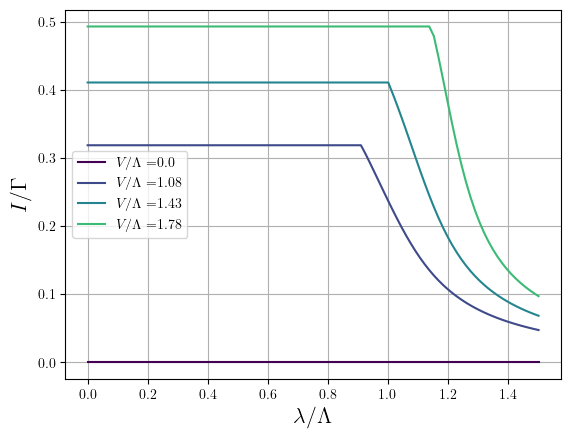

In [24]:
plt.plot()
for i in range(phi_lambda.shape[0]):
    plt.plot(lambdaSpacePlot, currentLambdaVolt[i,:]/couplingValue, label=r'$V/\Lambda = $'+str(round(voltageSamples[i], 2)), color=colorsVoltage[i])
plt.legend()
plt.grid()
plt.xlabel(r'$\lambda/\Lambda$', fontsize=16)
plt.ylabel(r'$I/\Gamma$', fontsize=16)
plt.savefig('figures/CurrentMFLambda.pdf')